In [131]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from scipy.stats import zscore

from convnwb.io import load_nwbfile,make_session_name

from spiketools.spatial.occupancy import (compute_occupancy, compute_trial_occupancy,compute_bin_edges,
                                          compute_bin_counts_pos, normalize_bin_counts)
from spiketools.spatial.information import compute_spatial_information
from spiketools.spatial.place import compute_place_bins, compute_trial_place_bins
from spiketools.spatial.utils import compute_pos_ranges, get_position_xy
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.plts.utils import make_axes, make_grid, get_grid_subplot, save_figure
from spiketools.plts.trials import plot_rasters
from spiketools.plts.spatial import plot_heatmap, plot_positions, plot_position_by_time,create_heatmap_title
from spiketools.plts.annotate import add_vlines, add_hlines,color_pvalue
from spiketools.plts.data import plot_bar, plot_hist, plot_text
from spiketools.plts.style import drop_spines
from spiketools.plts.stats import plot_surrogates

from spiketools.utils.extract import (get_range, get_values_by_time_range,
                                      get_values_by_times, threshold_spikes_by_values)
from spiketools.utils.epoch import epoch_spikes_by_range
from spiketools.utils.data import compute_range
from spiketools.utils import set_random_seed
from spiketools.utils.run import create_methods_list

from spiketools.utils.extract import drop_range,reinstate_range

In [132]:
import sys
sys.path.append('../code')
from models import PLACE_MODELS, PLACE_COND_MODELS, create_df_place, create_df_place_cond, fit_anova_place, fit_anova_place_cond
from utils import get_values_by_times
sys.path.append('../scripts')
from settings import RUN, PATHS,OCCUPANCY,OCCUPANCY_TRIAL, PLACE,UNITS,METHODS, SURROGATES,BINS

## Settings

In [133]:
set_random_seed(101)

## Subject Settings

In [134]:
data_folder = PATHS['DATA']

In [135]:
session = {
    'experiment' : 'TRAIN',
    'subject' : 'R1219C',
    'session' : '0'    
}

In [136]:
experiment = session['experiment']
subject = session['subject']
sess = session['session']
session_name = make_session_name(subject,experiment,sess)
session_name

'TRAIN_R1219C_session_0'

In [137]:
uid =19 

## Analysis Settings

In [138]:
OCCUPANCY
OCCUPANCY['min_speed'] = 1

In [139]:
OCCUPANCY_TRIAL['min_speed'] = 1

In [140]:
BINS

{'place': 40}

In [141]:
SURROGATES

{'approach': 'CIRCULAR', 'n_shuffles': 1000}

In [142]:
PLACE['min_speed'] = 1

In [143]:
results = {}

In [144]:
nwbfile, io = load_nwbfile(session, data_folder, return_io=True)

In [145]:
# Get the number of units
n_units = len(nwbfile.units)

In [146]:
# Get the position & related data from NWB file
positions = nwbfile.acquisition['position']['player_position'].data[:]
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
speed = nwbfile.processing['position_measures']['speed'].data[:]

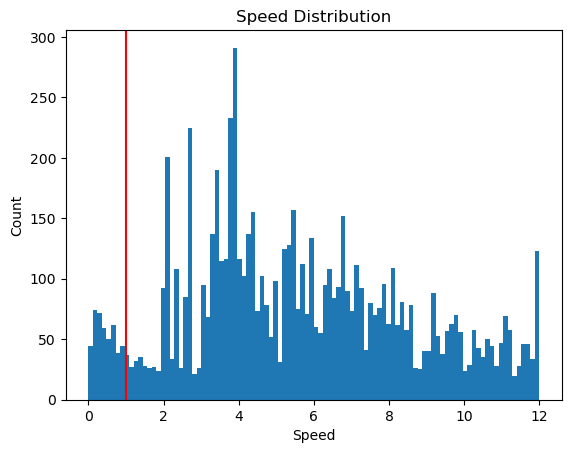

In [147]:
plot_hist(speed, bins=100, xlabel='Speed', ylabel='Count', title='Speed Distribution',)
add_vlines(PLACE['min_speed'], color='red')

In [148]:
# Compute the range of position data
area_range = compute_pos_ranges(positions)
area_range = [-34, 34]

In [149]:
# Collect together boundary ranges
print('Boundary range: ', area_range)

Boundary range:  [-34, 34]


In [150]:
# Get trial information - start & end times
n_trials = len(nwbfile.trials)
trial_starts = nwbfile.trials.start_time[:]
trial_stops = nwbfile.trials.stop_time[:]

In [151]:
trial_starts = nwbfile.trials['movement_start_time'][:]
trial_stops = nwbfile.trials['movement_stop_time'][:]


In [152]:
# # Drop manual trials 
manual_indx = np.where(nwbfile.trials['drive_type'][:] == 'manual')[0]
manual_start = trial_starts[manual_indx]
manual_end = trial_stops[manual_indx]

move_starts = trial_starts
move_stops = trial_stops


In [153]:
# Compute bin edges
x_edges = compute_bin_edges(positions, BINS['place'])

In [154]:
trial_type = nwbfile.trials['object'][:]
#trial_type = np.delete(trial_type, manual_indx, axis=0)
len(trial_type)

64

## Compute occupancy

/Users/weijiazhang/anaconda3/lib/python3.11/site-packages/spiketools/utils/checks.py:288: UserWarning: The data values extend beyond the given bin definition.
  warnings.warn(msg)


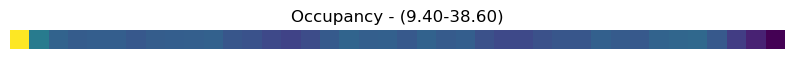

In [155]:
## Compute Occupancy 
occ = compute_occupancy(positions, ptimes, BINS['place'], area_range, speed,**OCCUPANCY)

# Plot the occupancy
plot_heatmap(occ, title= create_heatmap_title('Occupancy', occ), figsize=(10, 6))


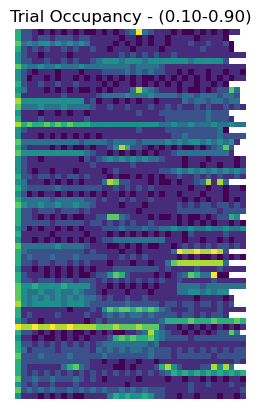

In [156]:
trial_occupancy = compute_trial_occupancy(positions, ptimes, BINS['place'],move_starts, move_stops,
                                               area_range,speed, **OCCUPANCY_TRIAL)
# Plot the occupancy
plot_heatmap(trial_occupancy, title= create_heatmap_title('Trial Occupancy', trial_occupancy))

In [76]:
# n_bins = 40
# epoch_size = .1
# position = (positions - (-34))/68
# position = np.clip(position, 0, 1)
    
# # Bin positions into percentages along track
# edges = np.linspace(0, 100, n_bins+1)
# counts, pos_bin = np.histogram(position*100, bins=np.append(edges, 101))
    
# # Calculate time spent in each bin
# counts = counts[:n_bins]
# time_in_bin = counts * epoch_size

# #Compute trial occupancy
# trial_occupancy = np.zeros((len(move_starts), n_bins))
# for trial_idx, (start, stop) in enumerate(zip(move_starts, move_stops)):
#     trial_mask = (ptimes >= start) & (ptimes < stop)
#     trial_pos = position[trial_mask]
#     trial_counts, _ = np.histogram(trial_pos*100, bins=np.append(edges, 101))
#     trial_occupancy[trial_idx] = trial_counts[:n_bins] * epoch_size

In [157]:
# Smooth trial occupancy with Gaussian kernel
kernel_size = 5
gaussian_kernel = signal.windows.gaussian(kernel_size, std=1)
gaussian_kernel = gaussian_kernel / np.sum(gaussian_kernel)  # Normalize kernel

# Apply smoothing to each trial's occupancy
smoothed_trial_occupancy = np.zeros_like(trial_occupancy)
for trial_idx in range(trial_occupancy.shape[0]):
    # Pad the trial data to handle edge effects
    padded = np.pad(trial_occupancy[trial_idx], (kernel_size//2, kernel_size//2), mode='edge')
    # Apply convolution
    smoothed = np.convolve(padded, gaussian_kernel, mode='valid')
    smoothed_trial_occupancy[trial_idx] = smoothed


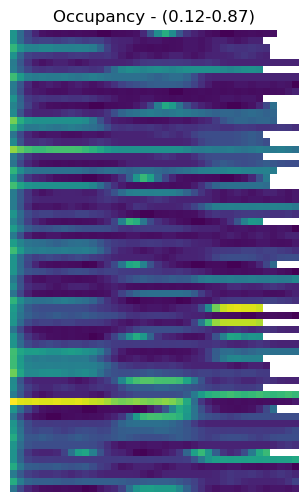

In [158]:
#plot_heatmap(speed_occupancy, title= create_heatmap_title('Occupancy', speed_occupancy), figsize=(10, 6))
plot_heatmap(smoothed_trial_occupancy, title= create_heatmap_title('Occupancy', smoothed_trial_occupancy), figsize=(10, 6))

## Spiking

In [159]:
# Get spikes for unit of interest
spikes = nwbfile.units.get_unit_spike_times(uid)

In [160]:
spike_positions,indx = get_values_by_times(ptimes, positions, spikes,time_threshold =PLACE['time_threshold'])
spike_t = ptimes[indx]

In [161]:
spike_positions,indx = get_values_by_times(ptimes, positions, spikes,time_threshold =PLACE['time_threshold'])
spike_t = ptimes[indx]

In [162]:
x_edges

positions_bin = pd.cut(positions, bins=40, right=False, labels=np.arange(0,40))

In [163]:
# Initialize dictionary to store spikes by position bin and trial
spikes_by_pbin_trial = {x:{} for x in positions_bin.unique()}

# For each trial
for trial_idx, (start, stop) in enumerate(zip(move_starts, move_stops)):
    # Get positions and times for this trial
    trial_mask = (ptimes >= start) & (ptimes < stop)
    trial_positions = positions_bin[trial_mask]
    trial_times = ptimes[trial_mask]
    
    # Initialize spike counts for this trial
    for pbin in positions_bin.unique():
        spikes_by_pbin_trial[pbin][trial_idx] = []
    
    # Count spikes in each position bin for this trial
    for ix, (pbin, t) in enumerate(zip(trial_positions, trial_times)):
        if ix < len(trial_times)-1:
            st_in_position = spikes[(spikes >= t) & (spikes < trial_times[ix+1])]
            spikes_by_pbin_trial[pbin][trial_idx].append(st_in_position)

In [164]:
# Count spikes in each position bin for each trial
trial_bin_spike_counts = np.zeros((len(move_starts), len(positions_bin.unique())))

for trial_idx in range(len(move_starts)):
    for bin_idx, pbin in enumerate(positions_bin.unique()):
        if trial_idx in spikes_by_pbin_trial[pbin]:
            # Sum spikes across all time points in this bin for this trial
            bin_spikes = [len(spike_array) for spike_array in spikes_by_pbin_trial[pbin][trial_idx]]
            trial_bin_spike_counts[trial_idx, bin_idx] = sum(bin_spikes)

trial_bin_spike_counts.shape

(64, 40)

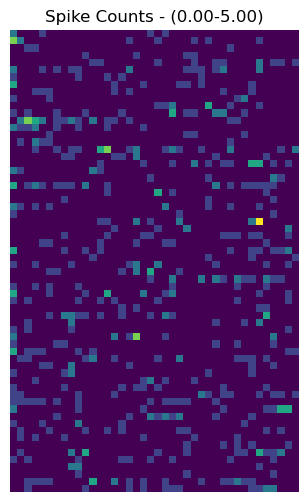

In [165]:
plot_heatmap(trial_bin_spike_counts, title= create_heatmap_title('Spike Counts', trial_bin_spike_counts), figsize=(10, 6))

/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_29424/2352428897.py:3: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gaussian_kernel = signal.gaussian(kernel_size, std=1)


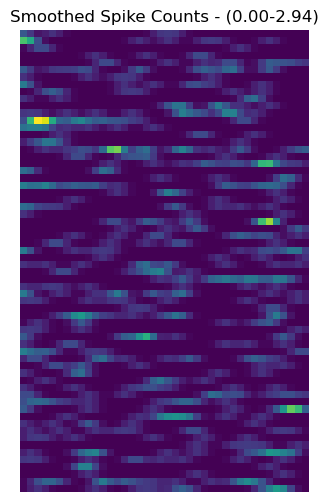

In [166]:
# Smooth spike counts with Gaussian kernel
kernel_size = 5  # Adjust kernel size as needed
gaussian_kernel = signal.gaussian(kernel_size, std=1)
gaussian_kernel = gaussian_kernel / np.sum(gaussian_kernel)  # Normalize

# Smooth each trial's spike counts
smoothed_spike_counts = np.zeros_like(trial_bin_spike_counts)
for trial_idx in range(trial_bin_spike_counts.shape[0]):
    # Apply convolution with periodic boundary conditions
    smoothed_spike_counts[trial_idx] = np.convolve(
        trial_bin_spike_counts[trial_idx], 
        gaussian_kernel, 
        mode='same'
    )

plot_heatmap(smoothed_spike_counts, title= create_heatmap_title('Smoothed Spike Counts', smoothed_spike_counts), figsize=(10, 6))


In [167]:
smoothed_trial_place_bins = smoothed_spike_counts/smoothed_trial_occupancy

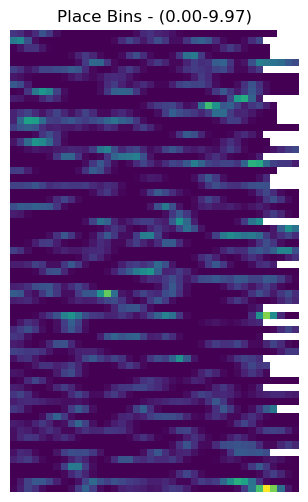

In [168]:
trial_place_bins = trial_bin_spike_counts/trial_occupancy
plot_heatmap(smoothed_trial_place_bins, title= create_heatmap_title('Place Bins', smoothed_trial_place_bins), figsize=(10, 6))

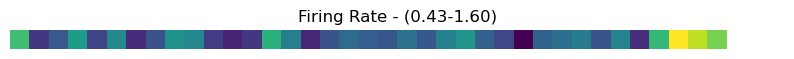

In [169]:
fr_by_bin = np.mean(trial_place_bins, axis=0)
plot_heatmap(fr_by_bin, title= create_heatmap_title('Firing Rate', fr_by_bin), figsize=(10, 6))



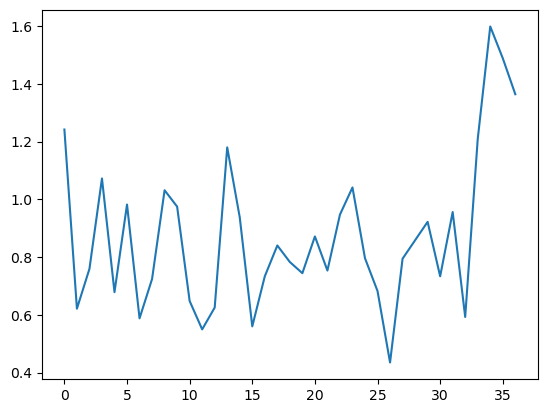

In [170]:
plt.plot(fr_by_bin)

In [171]:
df = create_df_place(trial_place_bins)
results['place_anova'] = fit_anova_place(df)
results['place_anova']



0.8338171043115518

In [172]:
results['place_info'] = compute_spatial_information(fr_by_bin, occ, normalize=False)
print(results['place_info'])

0.13837553921730647


In [173]:
import numpy as np
from scipy import signal

            # Create Gaussian smoothing kernel
kernel_size = 6 # Adjust kernel size as needed
gaussian_kernel = signal.gaussian(kernel_size, std=1)
gaussian_kernel = gaussian_kernel / np.sum(gaussian_kernel)  # Normalize

            # Apply smoothing to trial data
smoothed_trials = np.zeros_like(trial_place_bins)
for trial in range(trial_place_bins.shape[0]):
    smoothed_trials[trial] = signal.convolve(trial_place_bins[trial], gaussian_kernel, mode='same')

            # Apply smoothing to occupancy data 
    smoothed_occupancy = signal.convolve(occ, gaussian_kernel, mode='same')




/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_29424/3125203190.py:6: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gaussian_kernel = signal.gaussian(kernel_size, std=1)


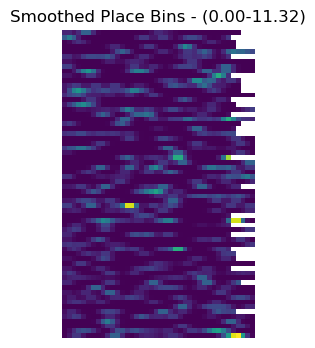

In [174]:
plot_heatmap(smoothed_trials, title= create_heatmap_title('Smoothed Place Bins', smoothed_trials), figsize=(5, 4))

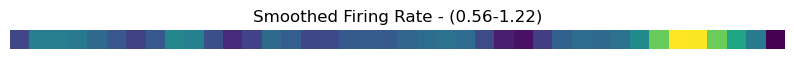

In [175]:
place_bins = smoothed_trial_place_bins
fr_by_bin = np.nanmean(place_bins, axis=0)
plot_heatmap(fr_by_bin, title= create_heatmap_title('Smoothed Firing Rate', fr_by_bin), figsize=(10, 6))


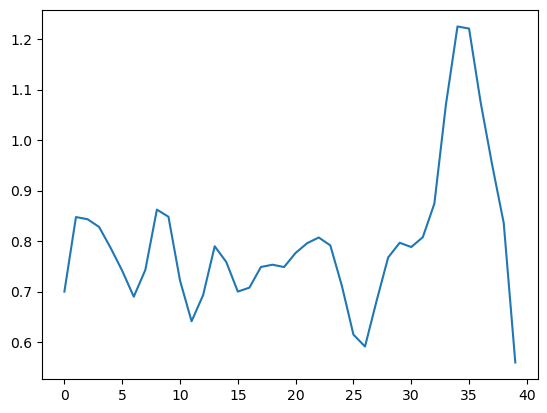

In [176]:
plt.plot(fr_by_bin)

In [129]:
df = create_df_place(smoothed_trials)
results['place_anova'] = fit_anova_place(df)
results['place_anova']

1.0222757472091994